# Customer Segmentation & Colaborative Filtering

In today's competitive landscape, identifying the right group of customers for a particular product drives business growth. However, the traditional approaches often struggle to capture and utilize the vast amounts of customer data available. To address this challenge, there is a need for AI-powered solutions that can analyze the customer data, their relationship, predict customer behavior, and generate the personalized recommendations

**Dataset represents real customers & orders data between November 2018 - April 2019 and it is pseudonymized for confidentiality.**

**Can this customer database be grouped to develop customized relationships?** 

**To answer this question 3 features will be created and used:**
* Products Ordered
* Average Return Rate
* Total Spending

In [33]:
import copy
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer

warnings.filterwarnings("ignore")

In [2]:
# Constatns
DATA_PATH = "../Backend/Data/Orders - Analysis Task.csv"

In [3]:
df = pd.read_csv(DATA_PATH)
print(f"The DataFrame has {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

The DataFrame has 70052 rows and 17 columns


,product_title,product_type,variant_title,variant_sku,variant_id,customer_id,order_id,day,net_quantity,gross_sales,discounts,returns,net_sales,taxes,total_sales,returned_item_quantity,ordered_item_quantity
0,DPR,DPR,100,AD-982-708-895-F-6C894FB,52039657,1312378,83290718932496,04/12/2018,2,200.0,-200.00,0.00,0.0,0.0,0.0,0,2
1,RJF,Product P,28 / A / MTM,83-490-E49-8C8-8-3B100BC,56914686,3715657,36253792848113,01/04/2019,2,190.0,-190.00,0.00,0.0,0.0,0.0,0,2
2,CLH,Product B,32 / B / FtO,68-ECA-BC7-3B2-A-E73DE1B,24064862,9533448,73094559597229,05/11/2018,0,164.8,-156.56,-8.24,0.0,0.0,0.0,-2,2
3,NMA,Product F,40 / B / FtO,6C-1F1-226-1B3-2-3542B41,43823868,4121004,53616575668264,19/02/2019,1,119.0,-119.00,0.00,0.0,0.0,0.0,0,1
4,NMA,Product F,40 / B / FtO,6C-1F1-226-1B3-2-3542B41,43823868,4121004,29263220319421,19/02/2019,1,119.0,-119.00,0.00,0.0,0.0,0.0,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70052 entries, 0 to 70051
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   product_title           70052 non-null  object 
 1   product_type            70052 non-null  object 
 2   variant_title           70052 non-null  object 
 3   variant_sku             70052 non-null  object 
 4   variant_id              70052 non-null  int64  
 5   customer_id             70052 non-null  int64  
 6   order_id                70052 non-null  int64  
 7   day                     70052 non-null  object 
 8   net_quantity            70052 non-null  int64  
 9   gross_sales             70052 non-null  float64
 10  discounts               70052 non-null  float64
 11  returns                 70052 non-null  float64
 12  net_sales               70052 non-null  float64
 13  taxes                   70052 non-null  float64
 14  total_sales             70052 non-null

In [5]:
# Filter out customers that ordered_item_quantity < 0
# That is the customers acutally ordered/saled

df = df[df["ordered_item_quantity"] > 0]

## 1. Products ordered
It is the count of the products ordered in product_type column by a customer.

**This can identify customers who order multiple products**

In [6]:
customer_product_order = pd.DataFrame(df.groupby(["customer_id", "product_type"])["ordered_item_quantity"].count()).reset_index()
customer_order = pd.DataFrame(customer_product_order.groupby(["customer_id"])["ordered_item_quantity"].sum()).reset_index()
customer_order.head()

,customer_id,ordered_item_quantity
0,1000661,3
1,1001914,1
2,1002167,3
3,1002387,1
4,1002419,2


## 2. Recency
The number of days between the last purchase made by a customer and a reference date, usually the current or max date available in the data.

In [7]:
# Conver day column to datetime
df["day"] = pd.to_datetime(df["day"], format="%d/%m/%Y")

# max date
max_date = df["day"].max()

def calculate_recency(date, max_date=max_date):
    return (max_date - date).days

# Create Customer Recency Dataframe
customer_recency = pd.DataFrame(df.groupby(["customer_id"])["day"].max())
customer_recency["recency"] = customer_recency["day"].apply(lambda x: calculate_recency(x))
customer_recency.reset_index(inplace=True)

In [8]:
customer_recency.head()

,customer_id,day,recency
0,1000661,2018-11-23,158
1,1001914,2018-11-23,158
2,1002167,2019-03-08,53
3,1002387,2019-03-17,44
4,1002419,2019-01-06,114


## 3. Total spending
Total spending is the aggregated sum of total sales value which is the amount after the taxes and returns.

In [9]:
customer_total_spending = pd.DataFrame(df.groupby("customer_id")["total_sales"].sum()).reset_index()
customer_total_spending.head()

,customer_id,total_sales
0,1000661,260.0
1,1001914,79.2
2,1002167,234.2
3,1002387,89.0
4,1002419,103.0


## 4. Product Order Vector

In [10]:
# Create Order Details Model
order_details = pd.DataFrame(df.groupby(["customer_id", "product_type"])["ordered_item_quantity"].count()).reset_index()

# Create a new dataframe with the desired columns
product_orders = order_details.pivot_table(index='customer_id', columns='product_type', values='ordered_item_quantity', aggfunc=sum)

# Fill missing values with 0
product_orders.fillna(0, inplace=True)

# Format the Product Order df
product_orders = product_orders.astype(int).reset_index()
product_orders.columns.name = None

In [11]:
product_orders.head()

,customer_id,DPR,Product A,Product B,Product C,Product D,Product E,Product F,Product G,Product H,...,Product L,Product M,Product N,Product O,Product P,Product Q,Product R,Product T,Product U,Product W
0,1000661,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0
1,1001914,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1002167,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
3,1002387,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1002419,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


## 5. Customer Segmentation

In [12]:
customer_segmentation_raw = pd.merge(customer_order, customer_recency, on="customer_id")
customer_segmentation_raw = pd.merge(customer_segmentation_raw, customer_total_spending, on="customer_id")
customer_segmentation_raw.drop(["day"], axis=1, inplace=True)
customer_segmentation_raw.head()

,customer_id,ordered_item_quantity,recency,total_sales
0,1000661,3,158,260.0
1,1001914,1,158,79.2
2,1002167,3,53,234.2
3,1002387,1,44,89.0
4,1002419,2,114,103.0


In [14]:
customer_segmentation_raw.describe()

,customer_id,ordered_item_quantity,recency,total_sales
count,2.487400e+04,24874.000000,24874.000000,24874.000000
mean,6.566304e+11,2.385503,85.811329,191.245288
std,6.560350e+12,2.114809,55.804788,171.100082
min,1.000661e+06,1.000000,0.000000,0.000000
25%,3.296314e+06,1.000000,35.000000,89.000000
50%,5.578172e+06,2.000000,86.000000,142.400000
75%,7.845900e+06,3.000000,135.000000,237.000000
max,9.954992e+13,39.000000,180.000000,3131.700000


In [15]:
customer_segmentation = copy.deepcopy(customer_segmentation_raw)
for col in customer_segmentation.columns.tolist()[1:]:
    scaler = RobustScaler()
    customer_segmentation[col] = scaler.fit_transform(np.array(customer_segmentation[col]).reshape(-1, 1))


customer_segmentation.head()

,customer_id,ordered_item_quantity,recency,total_sales
0,1000661,0.5,0.72,0.794595
1,1001914,-0.5,0.72,-0.427027
2,1002167,0.5,-0.33,0.620270
3,1002387,-0.5,-0.42,-0.360811
4,1002419,0.0,0.28,-0.266216


In [16]:
customer_segmentation.describe()

,customer_id,ordered_item_quantity,recency,total_sales
count,2.487400e+04,24874.000000,24874.000000,24874.000000
mean,6.566304e+11,0.192751,-0.001887,0.330036
std,6.560350e+12,1.057404,0.558048,1.156082
min,1.000661e+06,-0.500000,-0.860000,-0.962162
25%,3.296314e+06,-0.500000,-0.510000,-0.360811
50%,5.578172e+06,0.000000,0.000000,0.000000
75%,7.845900e+06,0.500000,0.490000,0.639189
max,9.954992e+13,18.500000,0.940000,20.197973


In [17]:
def make_list_of_K(K, dataframe):
    '''inputs: K as integer and dataframe
    apply k-means clustering to dataframe
    and make a list of inertia values against 1 to K
    return the inertia values list
    '''
    X = dataframe.values
    cluster_values = list(range(1, K+1))
    inertia_values=[]

    for c in cluster_values:
        model = KMeans(
            n_clusters = c, 
            init='k-means++', 
            max_iter=500, 
            random_state=13)
        model.fit(X)
        inertia_values.append(model.inertia_)
    
    return inertia_values

In [18]:
inertia_values = make_list_of_K(10, customer_segmentation.iloc[:,1:])
k_values_distances = pd.DataFrame({"clusters": [i+1 for i in range(len(inertia_values))],
                                "inertia_score": inertia_values})

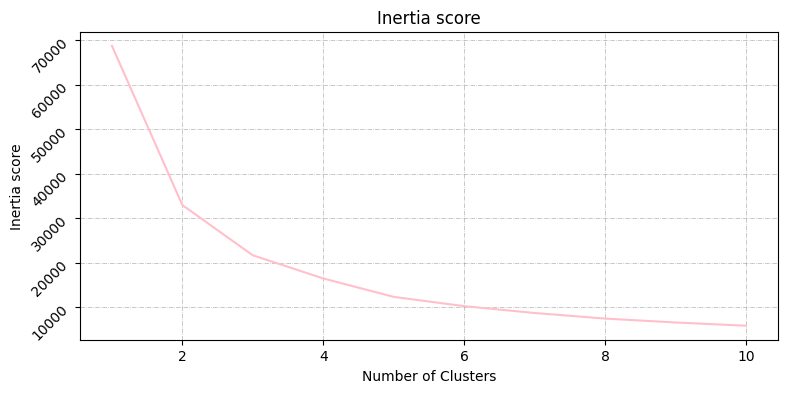

In [19]:
# Create the line plot
plt.figure(figsize=(9,4))
plt.plot(k_values_distances["clusters"], 
        k_values_distances["inertia_score"],
        color="pink")
plt.grid(color ='grey',
        linestyle ='-.', 
        linewidth = 0.5,
        alpha = 0.6)
plt.xlabel("Number of Clusters")

plt.ylabel("Inertia score")
plt.yticks(rotation = 45)

plt.title("Inertia score");


In [20]:
# Update Kmeans

# Create clustering model with optimal k=4
updated_kmeans_model = KMeans(n_clusters = 4, 
                              init='k-means++', 
                              max_iter=500, 
                              random_state=13)

cluster_name = updated_kmeans_model.fit_predict(customer_segmentation.iloc[:,1:])

In [21]:
customer_segmentation_plot = copy.deepcopy(customer_segmentation.iloc[:, 1:])
customer_segmentation_plot["cluster_name"] = cluster_name
customer_segmentation_plot.head()

,ordered_item_quantity,recency,total_sales,cluster_name
0,0.5,0.72,0.794595,0
1,-0.5,0.72,-0.427027,2
2,0.5,-0.33,0.620270,0
3,-0.5,-0.42,-0.360811,2
4,0.0,0.28,-0.266216,2


In [22]:
fig = px.scatter_3d(customer_segmentation_plot,
                x = "ordered_item_quantity",
                y = "recency",
                z = "total_sales",
                color = "cluster_name",
                hover_data=["ordered_item_quantity",
                            "recency",
                            "total_sales"],
                category_orders = {"cluster_name": 
                                ["0", "1", "2", "3"]},)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [23]:
customer_segmentation_raw["cluster_name"] = cluster_name
customer_segmentation_raw.head()

,customer_id,ordered_item_quantity,recency,total_sales,cluster_name
0,1000661,3,158,260.0,0
1,1001914,1,158,79.2,2
2,1002167,3,53,234.2,0
3,1002387,1,44,89.0,2
4,1002419,2,114,103.0,2


In [25]:
customer_segmentation_raw[customer_segmentation_raw["cluster_name"] == 0].describe()

,customer_id,ordered_item_quantity,recency,total_sales,cluster_name
count,5.744000e+03,5744.000000,5744.000000,5744.000000,5744.0
mean,6.159366e+11,3.568245,69.399373,284.152002,0.0
std,6.374536e+12,0.806906,52.568498,65.517126,0.0
min,1.000661e+06,2.000000,0.000000,0.000000,0.0
25%,3.322212e+06,3.000000,23.000000,235.000000,0.0
50%,5.594214e+06,3.000000,57.000000,273.000000,0.0
75%,7.823718e+06,4.000000,117.000000,330.325000,0.0
max,9.926273e+13,10.000000,180.000000,546.000000,0.0


In [26]:
customer_segmentation_raw[customer_segmentation_raw["cluster_name"] == 1].describe()

,customer_id,ordered_item_quantity,recency,total_sales,cluster_name
count,1.722000e+03,1722.000000,1722.000000,1722.000000,1722.0
mean,3.722342e+11,7.015679,49.646922,567.931649,1.0
std,4.694818e+12,1.613168,47.584753,121.506755,0.0
min,1.008012e+06,2.000000,0.000000,320.600000,1.0
25%,3.391632e+06,6.000000,9.250000,474.000000,1.0
50%,5.549250e+06,7.000000,34.000000,541.000000,1.0
75%,7.822701e+06,8.000000,75.750000,641.975000,1.0
max,8.909210e+13,14.000000,177.000000,1030.800000,1.0


In [27]:
customer_segmentation_raw[customer_segmentation_raw["cluster_name"] == 2].describe()

,customer_id,ordered_item_quantity,recency,total_sales,cluster_name
count,1.720800e+04,17208.000000,17208.000000,17208.000000,17208.0
mean,6.998718e+11,1.380114,95.543759,110.626473,2.0
std,6.787146e+12,0.506635,54.664791,45.053852,0.0
min,1.001914e+06,1.000000,0.000000,0.000000,2.0
25%,3.286465e+06,1.000000,48.000000,74.000000,2.0
50%,5.570772e+06,1.000000,107.000000,95.000000,2.0
75%,7.855435e+06,2.000000,146.000000,150.100000,2.0
max,9.954992e+13,5.000000,180.000000,300.000000,2.0


In [28]:
customer_segmentation_raw[customer_segmentation_raw["cluster_name"] == 3].describe()

,customer_id,ordered_item_quantity,recency,total_sales,cluster_name
count,2.000000e+02,200.000000,200.00000,200.000000,200.0
mean,5.535165e+11,15.055000,31.16000,1216.137750,3.0
std,5.653861e+12,4.571264,35.17886,370.610887,0.0
min,1.003899e+06,5.000000,0.00000,757.900000,3.0
25%,3.134091e+06,12.000000,4.75000,966.237500,3.0
50%,5.720784e+06,14.000000,15.50000,1103.800000,3.0
75%,7.673515e+06,17.000000,46.00000,1332.250000,3.0
max,6.749701e+13,39.000000,155.00000,3131.700000,3.0


<ins>**Orange-2**</ins>: Customers who ordered at least one product and maximum 5 products, with maximum total spending of 300 and having the large average recency (146 days). They might be the newcomers of the e-commerce website.

<ins>**Blue-0**</ins>: Customers who ordered 2 to 10 products, with maximum total spending of 550 and slightly smaller average recency (117 days)

<ins>**Purple-1**</ins>: Customers who ordered 2 to 14 products, with maximum total spending of 1030 and small average recency (75 days)

<ins>**Yellow-3**</ins>: Customers who ordered 5 to 39 products, with maximum total spending of 3131 and minimum average recency is 46 days. It makes the most favourable customer group for the company.

Segmentation -> Customer Cohort -> Colaborator Filtering ->  TF-IDF

In [29]:
product_orders.head()

,customer_id,DPR,Product A,Product B,Product C,Product D,Product E,Product F,Product G,Product H,...,Product L,Product M,Product N,Product O,Product P,Product Q,Product R,Product T,Product U,Product W
0,1000661,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0
1,1001914,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1002167,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
3,1002387,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1002419,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [56]:
product_orders.iloc[0, :]

customer_id    1000661
DPR                  0
Product A            0
Product B            0
Product C            0
Product D            0
Product E            0
Product F            0
Product G            0
Product H            0
Product I            0
Product J            0
Product K            0
Product L            0
Product M            0
Product N            0
Product O            0
Product P            3
Product Q            0
Product R            0
Product T            0
Product U            0
Product W            0
Name: 0, dtype: int64

In [71]:
def ordered_product_set(id, product_orders=product_orders):
    product_set = set()
    product_dict = dict(product_orders[product_orders["customer_id"] == id].iloc[0,1:])
    # Iterate over the dictionary
    for key, value in product_dict.items():
        # Add the keys to the set if the values are different from zero
        if value != 0:
            product_set.add(key)
    return product_set

def recommend_product_set(id, product_orders=product_orders):
    product_set = set()
    product_dict = dict(product_orders.iloc[id,1:])
    # Iterate over the dictionary
    for key, value in product_dict.items():
        # Add the keys to the set if the values are different from zero
        if value != 0:
            product_set.add(key)
    return product_set

In [74]:
customer_segmentation_raw.head()

,customer_id,ordered_item_quantity,recency,total_sales,cluster_name
0,1000661,3,158,260.0,0
1,1000661,1,158,79.2,2
2,1000661,3,53,234.2,0
3,1000661,1,44,89.0,2
4,1000661,2,114,103.0,2


In [106]:
def customer_recommendations(target_customer_id,
                            customer_segmentation_raw=customer_segmentation_raw,
                            product_orders=product_orders,
                            k_recommendations=10):
    customer_corhort = customer_segmentation_raw[customer_segmentation_raw["customer_id"]==target_customer_id]["cluster_name"]
    target_product_vector = product_orders[product_orders["customer_id"] == target_customer_id]
    customer_corhort_df = customer_segmentation_raw[customer_segmentation_raw["cluster_name"] == customer_corhort]
    product_corhort_df = product_orders[product_orders["customer_id"].isin(customer_corhort_df["customer_id"].tolist())]
    target_vector = product_corhort_df[product_corhort_df["customer_id"]==target_customer_id].iloc[:,1:]
    
    distance_array = pairwise_distances(target_vector.values.reshape(1,-1), product_orders.iloc[:, 1:])[0]
    zeros = np.where(distance_array == 0)
    distance_array[zeros] = 100

    min_vals = np.partition(distance_array, k_recommendations)[:k_recommendations]
    min_indices = np.argpartition(distance_array, k_recommendations)[:k_recommendations]
    
    target_product_set = ordered_product_set(target_customer_id,product_orders)
    recommend_product_s = set()
    for i in min_indices:
        recommend_product_s.update(recommend_product_set(i))
    
    recommend_product = recommend_product_s.difference(target_product_set)
    return recommend_product

In [107]:
customer_recommendations(1000661)

{'Product H', 'Product W'}